In [15]:
import gc
import os
import itertools
import pickle
import re
import time
from random import choice, choices
from functools import reduce
from tqdm import tqdm
from itertools import cycle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from functools import reduce
from itertools import cycle
from scipy import stats
from scipy.stats import skew, kurtosis
from sklearn import metrics, model_selection, preprocessing, linear_model, ensemble, decomposition, tree
import lightgbm as lgb
import optuna
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor, StackingRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LinearRegression


import sys
sys.path.append('../../')
from utils import *

## Prepro: change names to numbers

In [16]:
train_feats = pd.read_csv('../../3_feature_eng/output/train_feats_double_corr.csv')
train_score = pd.read_csv('../../0_data/train_scores.csv')

# train_feats_first10min = pd.read_csv('../../feature_eng/output/train_double_corr_first_10min_786feats.csv')
# train_feats_second10min = pd.read_csv('../../feature_eng/output/train_double_corr_second_10min_786feats.csv')
# train_feats = train_feats.merge(train_feats_first10min, on='id', how='left')
# train_feats = train_feats.merge(train_feats_second10min, on='id', how='left')

if 'score' not in train_feats.columns:
    train_feats = pd.merge(train_feats, train_score, on='id', how='left')

train_feats.replace([np.inf, -np.inf], np.nan, inplace=True)
cols = train_feats.columns

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(train_feats['score'])

score_transformed = le.transform(train_feats['score'])

## Keep columns

In [17]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute", 
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD"
# 'idle', "cursor_visits"

endings_to_keep = [
    "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features",
    "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes",
    "punctuation", "key_mouse", "time_feat", "avg_event_per_minute", "fft",
    "avg_char_deletion_per_minute", "avg_char_insert_per_minute",
    "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies", "IWD",
    'idle', "cursor_visits"
]
endings_to_keep += ["id"]

dir_to_save = "stacking11"
stratification = True
n_jobs = -1
noise = False
iterations = 5
n_splits = 10

try:
    os.mkdir(dir_to_save)
except:
    print('Already exists')
    sys.exit()

# cols_to_keep = [col for col in train_feats.columns if col.endswith(tuple(endings_to_keep)) or col in ['id', 'score']]
cols_to_keep = [col for col in train_feats.columns if any(ending in col for ending in endings_to_keep) or col in ['id', 'score']]

with open(f'{dir_to_save}/feature_list.pkl', 'wb') as f:
    pickle.dump(cols_to_keep, f)

train_feats = train_feats[cols_to_keep]
print(len(train_feats.columns)-2)

1010


In [18]:
# Options:
# "count_bursts", "word_sent_parag_agg", "pressed_keys", "paussed_features"
# "segments_visit", "paragraph_ratios", "time_gaps", "cursor_word_changes"
# "punctuation", "key_mouse", "time_feat", "fft", "avg_event_per_minute",
# "avg_char_deletion_per_minute", "avg_char_insert_per_minute"
# "IKI_word", "IKI_sentence", "IKI_paragraph", "latencies"
# "IWD", "idle", "cursor_visits"
# "intro_punctuation", "body_punctuation", "conclusion_punctuation"
# "intro_aggs", "body_aggs", "conclusion_aggs", "IKI_actual"
# "bursts_v2"

# manual_list

endings_1 = ["count_bursts", "-word_sent_parag_agg", "punctuation", "cursor_visits", "IWD", "intro_punctuation", "body_punctuation", "conclusion_punctuation", "intro_aggs", "body_aggs", "conclusion_aggs"]
feats_1 = [col for col in train_feats.columns if any(ending in col for ending in endings_1)]

endings_2 = ["pressed_keys", "paussed_features", "segments_visit", "paragraph_ratios", "fft", "bursts_v2"]
feats_2 = [col for col in train_feats.columns if any(ending in col for ending in endings_2)]

endings_3 = ["intro_punctuation", "body_punctuation", "conclusion_punctuation", "intro_aggs", "body_aggs", "conclusion_aggs", "key_mouse", "avg_char_deletion_per_minute"]
feats_3 = [col for col in train_feats.columns if any(ending in col for ending in endings_3)]

endings_4 = ["time_feat", "time_gaps", "cursor_word_changes", "IWD"]
feats_4 = [col for col in train_feats.columns if any(ending in col for ending in endings_4)]

In [19]:
counter = 0
new_columns = {}
for col in cols:
    if col != 'id' and col != 'score':
        new_columns[col] = counter
        counter += 1

train_feats.rename(columns=new_columns, inplace=True)

# Rename columns
feats_1 = [v for k, v in new_columns.items() if k in feats_1]
feats_2 = [v for k, v in new_columns.items() if k in feats_2]
feats_3 = [v for k, v in new_columns.items() if k in feats_3]
feats_4 = [v for k, v in new_columns.items() if k in feats_4]

In [20]:
with open(f'{dir_to_save}/new_col_dict.pkl', 'wb') as f:
    pickle.dump(new_columns, f)

In [21]:
target_col = ['score']
drop_cols = ['id']
train_cols = [col for col in train_feats.columns if col not in target_col + drop_cols]

In [22]:
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, feature_names):
        self.feature_names = feature_names

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.feature_names]

In [23]:
xgb_params = {'lambda': 0.16, 'alpha': 0.001, 'colsample_bytree': 0.4, 'colsample_bynode': 0.7, 'colsample_bylevel': 0.9, 'subsample': 0.9, 'learning_rate': 0.008, 'n_estimators': 750, 'max_depth': 3}
lgb_params = {'reg_lambda': 7.5, 'reg_alpha': 0.0004, 'colsample_bytree': 0.7, 'colsample_bynode': 0.8, 'subsample': 0.9, 'learning_rate': 0.005, 'max_depth': 15, 'min_child_samples': 13, 'num_leaves': 10, 'n_estimators': 1000}
cat_params = {'iterations': 1250, 'learning_rate': 0.01, 'depth': 10, 'reg_lambda': 0.0005, 'min_data_in_leaf': 60}

In [24]:
def stack_calc_OOF(x_train, y_train, x_valid, y_valid, iter, split, RANDOM_STATE=42, noise=False):

    # lr_pipeline = make_pipeline(
    #     SimpleImputer(strategy='median'),
    #     MinMaxScaler(feature_range=(-1, 1)),
    #     LinearRegression()
    # )

    svr_pipeline = make_pipeline(
        SimpleImputer(strategy='median'),
        MinMaxScaler(feature_range=(-1, 1)),
        SVR()
    )

    lgb_all_params = {
        "objective": "rmse",
        "metric": "rmse",
        'random_state': RANDOM_STATE,
        "verbosity": -1,
        "n_jobs": -1,
        **lgb_params
    }

    xgb_all_params = {
        'tree_method':'exact',
        'objective': 'reg:squarederror',
        'eval_metric': ['rmse'],
        'seed': RANDOM_STATE,
        'nthread': -1,
        **xgb_params
    }

    cat_all_params = {
        'loss_function': 'RMSE',
        'eval_metric': 'RMSE',
        'random_seed': RANDOM_STATE,
        "task_type":"CPU",
        'silent': True,
        # **cat_params
    }


    estimators = [
        ('lgb1', make_pipeline(FeatureSelector(feats_1), lgb.LGBMRegressor(**lgb_all_params))),
        # ('lgb2', make_pipeline(FeatureSelector(feats_2), lgb.LGBMRegressor(**lgb_all_params))),
        # ('lgb3', make_pipeline(FeatureSelector(feats_3), lgb.LGBMRegressor(**lgb_all_params))),
        # ('lgb4', make_pipeline(FeatureSelector(feats_4), lgb.LGBMRegressor(**lgb_all_params))),
        ('xgb1', make_pipeline(FeatureSelector(feats_1), xgb.XGBRegressor(**xgb_all_params))),
        # ('xgb2', make_pipeline(FeatureSelector(feats_2), xgb.XGBRegressor(**xgb_all_params))),
        # ('xgb3', make_pipeline(FeatureSelector(feats_3), xgb.XGBRegressor(**xgb_all_params))),
        # ('xgb4', make_pipeline(FeatureSelector(feats_4), xgb.XGBRegressor(**xgb_all_params))),
        ('cat1', make_pipeline(FeatureSelector(feats_1), CatBoostRegressor(**cat_all_params))),
        # ('cat2', make_pipeline(FeatureSelector(feats_2), CatBoostRegressor(**cat_all_params))),
        # ('cat3', make_pipeline(FeatureSelector(feats_3), CatBoostRegressor(**cat_all_params))),
        # ('cat4', make_pipeline(FeatureSelector(feats_4), CatBoostRegressor(**cat_all_params))),
        ('svr1', make_pipeline(FeatureSelector(feats_1), svr_pipeline)),
        # ('svr2', make_pipeline(FeatureSelector(feats_2), svr_pipeline)),
        # ('svr3', make_pipeline(FeatureSelector(feats_3), svr_pipeline)),
        # ('svr4', make_pipeline(FeatureSelector(feats_4), svr_pipeline)),
    ]

    model = StackingRegressor(
        estimators=estimators,
        final_estimator=svr_pipeline,
        passthrough=False,
        cv=10,
    )

    if noise:
        y_train = y_train + np.random.normal(0, 0.10, y_train.shape)
    y_train = np.maximum(y_train, 1)
    y_train = np.minimum(y_train, 5.5)
    
    model.fit(x_train, y_train.values.ravel())
    
    with open(f'./{dir_to_save}/stack_iter{iter}_split{split}_val.pkl', 'wb') as f:
        pickle.dump(model, f)

    # Predict
    valid_predict = model.predict(x_valid)
    print(f'RMSE: {mean_squared_error(y_valid, valid_predict, squared=False)}')

    # Return OOFs
    return valid_predict

In [25]:
OOF_SCORE = np.zeros(len(train_feats))

models_dict = {}
preds_dict = {}
count = 0
for _ in train_feats['id'].unique():
    preds_dict[count] = []
    count+=1


for i in range(iterations):

    print(f'Iterations: {i+1}/{iterations}')

    if stratification:
        kf = model_selection.StratifiedKFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats, score_transformed)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = stack_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

    else:
        kf = model_selection.KFold(n_splits=n_splits, random_state=41 + i, shuffle=True)
        j = 0
        for fold, (train_idx, valid_idx) in enumerate(kf.split(train_feats)):
            
            X_train, y_train = train_feats.iloc[train_idx][train_cols], train_feats.iloc[train_idx][target_col]
            X_valid, y_valid = train_feats.iloc[valid_idx][train_cols], train_feats.iloc[valid_idx][target_col]

            valid_predict = stack_calc_OOF(X_train, y_train, X_valid, y_valid, i, j, RANDOM_STATE=41 + i)

            OOF_SCORE[valid_idx] += valid_predict / iterations
            j+=1

Iterations: 1/5


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RMSE: 0.6054973678487626
RMSE: 0.6385427115065576
RMSE: 0.5931107988472826
RMSE: 0.6135864571604157
RMSE: 0.6593230483681206
RMSE: 0.5533661297928106
RMSE: 0.6192153157886353
RMSE: 0.5978165216858954
RMSE: 0.5682935672051108
RMSE: 0.6386616231007103
Iterations: 2/5


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RMSE: 0.5937275849685745
RMSE: 0.5841903220921527
RMSE: 0.5912922212445234
RMSE: 0.6034280447629027
RMSE: 0.5645995520236422
RMSE: 0.5812824645935206
RMSE: 0.608445285208748
RMSE: 0.6224845394200099
RMSE: 0.625303022138698
RMSE: 0.675247621195351
Iterations: 3/5


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RMSE: 0.6127509802166622
RMSE: 0.6112663207240895
RMSE: 0.6132942565883657
RMSE: 0.5901417574177946
RMSE: 0.5893783604923174
RMSE: 0.6160532312482837
RMSE: 0.6492400621906709
RMSE: 0.5894186961870971
RMSE: 0.5913613667440765
RMSE: 0.5954562259487203
Iterations: 4/5


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RMSE: 0.614681686882071
RMSE: 0.6098694793661079
RMSE: 0.6126742789084825
RMSE: 0.6430000858687441
RMSE: 0.6235518157065147
RMSE: 0.6146730331493594
RMSE: 0.5979500059270975
RMSE: 0.5761341523385891
RMSE: 0.5513330058984471
RMSE: 0.6420078662544964
Iterations: 5/5


c:\Users\luis.pinto1\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\model_selection\_split.py:700: UserWarning: The least populated class in y has only 5 members, which is less than n_splits=10.
  warnings.warn(


RMSE: 0.5954776826266536
RMSE: 0.5962791806863847
RMSE: 0.6144998246384897
RMSE: 0.600365166311206
RMSE: 0.6296344757492676
RMSE: 0.6332412053538476
RMSE: 0.6495700318543489
RMSE: 0.5699060188212782
RMSE: 0.5929824885256973
RMSE: 0.6132693300065314


In [29]:
print('OOF metric Stack = {:.5f}'.format(metrics.mean_squared_error(train_feats[target_col], 
                                                                   OOF_SCORE,
                                                                   squared=False)))

OOF metric Stack = 0.60574


In [27]:
# import pickle

# with open(f'{dir_to_save}/OOF_base_xgb.pkl', 'wb') as f:
#     pickle.dump(OOF_SCORE, f)

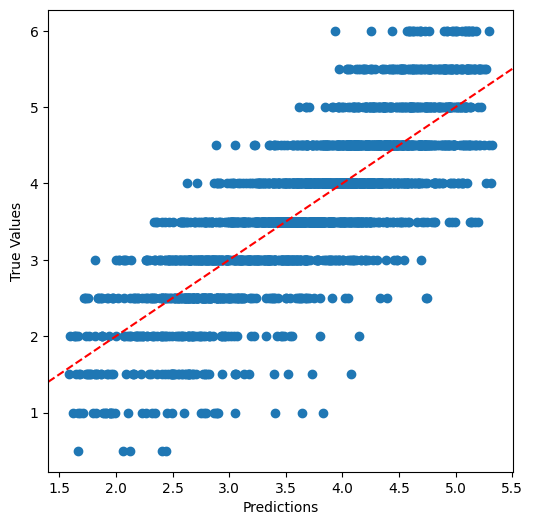

In [28]:
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(OOF_SCORE, train_feats['score'])
add_identity(ax, color='r', ls='--')
# ax.scatter(stds, train_scores_df['score']-means)
plt.ylabel('True Values')
plt.xlabel('Predictions')

plt.show()